# WWW-COURSERA-DOWNLOADER

Originally created by Jansen Simanullang, 2018.

My previous version of `www-coursera-downloader` dated back from 2016 is no longer working.

Sorry for the frustation of many people who have download my previous `www-coursera-downloader` and cannot use it.


## A. Requirements

### (1) Install Geckodriver
Install Geckodriver from : https://github.com/mozilla/geckodriver/releases/

#### Check Geckodriver version

In [1]:
!echo Checking geckodriver version...
!geckodriver --version

Checking geckodriver version...
geckodriver 0.20.1

The source code of this program is available from
testing/geckodriver in https://hg.mozilla.org/mozilla-central.

This program is subject to the terms of the Mozilla Public License 2.0.
You can obtain a copy of the license at https://mozilla.org/MPL/2.0/.


### (2) Install Some Python Packages

In [2]:
!pip install -q bs4 pillow splinter jupyter_contrib_nbextensions
!jupyter nbextension enable python-markdown/main

Enabling notebook extension python-markdown/main...
      - Validating: OK


In [3]:
from splinter import Browser
import base64, os, requests, sys, time
from bs4 import BeautifulSoup

## B. Definitions

### B. 1 Some constants

In [4]:
# adjust loading+time to your network speed~!
loading_time = 10

In [5]:
homepage='https://www.coursera.org'

In [6]:
resolution = {'low':'360','med':'540','hi':'720'}
# adjust chosen_res to your liking
chosen_res = 'hi'

In [7]:
initial_dirname = os.getcwd()

### B.2 Helper Function 

In [8]:
def screenshot():
    browser.driver.save_screenshot('screenshot.png')
    from PIL import Image
    return Image.open('screenshot.png')

In [9]:

def encode_cjson(text):
    return base64.b64encode(bytes(str(text), "utf-8"))

def save_cjson(text):
    text = encode_cjson(text)
    with open('coursera.json','wb+') as f:
        f.write(bytes(str(text),"utf-8"))
    f.close()

def read_cjson():
    import os
    if os.path.isfile('coursera.json'):
        with open('coursera.json','rb') as f:
            a = f.read()
        f.close()
    else:
        print('credential file not found')
    return str(a).split("'")[1]

def decode_cjson(text):
    return str(base64.b64decode(text)).split("'")[1]

def get_cjson():
    import json
    text = read_cjson()
    
    uid = json.loads(decode_cjson(text))
    return uid

def remove_cjson():
    import os
    if os.path.isfile('coursera.json'):
        os.remove('coursera.json')

def get_credential():
    import getpass, os
    if os.path.isfile('coursera.json'):
        username = get_cjson()['user']
        password = get_cjson()['password']
    else:
        username = input('User Name:')
        password = getpass.getpass('Password:')
        text = '{"user":"'+username+'", "password":"'+password+'"}'
        save_cjson(text)
        
    return username, password

def remove_credential():
    remove_cjson()
    print('credential removed...')
    return

def reset_credential():
    remove_cjson()
    username, password = get_credential()
    return username, password

In [10]:
def get_mp4_url(lesson_url):
    browser.visit(homepage+lesson_url)
    print('video playing will be paused in ' + str(loading_time) + ' seconds...')
    time.sleep(loading_time)
    try:
        browser.find_by_css('span.cif-2x.cif-fw.cif-pause').click()
    except:
        time.sleep(loading_time)
        try:
            browser.find_by_css('span.cif-2x.cif-fw.cif-pause').click()
        except:
            pass
        pass
    mp4 = browser.find_by_tag('video').find_by_tag('source')['src']
    mp4 = mp4.replace('360p/',resolution[chosen_res]+'p/')
    return mp4

In [11]:
def mp4_downloader(lesson_id, lesson_title, lesson_url):
    
    mp4 = get_mp4_url(lesson_url)
    file_name = lesson_id +'-'+ lesson_title + '.mp4'

    downloaded_size = 0
    buffer_size = 1024

    print('requesting to download...')
    r = requests.get(mp4)
    content_length = r.headers['Content-Length']
    download_size = int(content_length)
    file_exists = os.path.isfile(file_name)
    
    if file_exists:
        
        if os.path.getsize(file_name) == download_size:
            print('file already downloaded.')
            
    elif not file_exists:
        
        if r.status_code == 200:
            f = open(file_name, 'wb')
            for buffer in r.iter_content(buffer_size):
                f.write(buffer)
                downloaded_size += buffer_size
                status='\rdownloading...' + file_name + '>>> '
                status = status +str("{:.2f}".format(downloaded_size * 100. /download_size))+'%'
                sys.stdout.write(status)
                sys.stdout.flush()
            f.close()
        else:
            print('please check your connection..')
    

In [12]:
def safe_text(str_text):
    erasable = [':','/']
    for e in erasable:   
        str_text = str_text.replace(e, ' ')  
    while '  ' in str_text:
        str_text = str_text.replace('  ',' ')
    return str_text

In [13]:
def create_download_dir(dirname):
    
    dirname = safe_text(dirname)
    
    try:
        os.mkdir(dirname)
    except:
        pass
    
    os.chdir(dirname)
    print(os.getcwd())

In [14]:
def reformat_html(html, page_title):
    
    html = html.replace('<div class="rc-ItemBox rc-ReadingItem"><div class="item-box-content"><div>',
                  '<div class="rc-ItemBox rc-ReadingItem"><div class="item-box-content"><div> <h2 class="flex-1 align-self-center headline-4-text">'+page_title+'</h2>')

    html = html.replace('<div class="Box_120drhm-o_O-endJustify_b0g9ud-o_O-displayflex_poyjc" style="margin: 60px -60px -60px; border-top: 1px solid rgb(221, 221, 221); padding: 15px;"><div class="rc-ItemFeedback"><div class="rc-ItemFeedbackContent horizontal-box"><div class="rc-Like"><div class="rc-LikeContent"><div><button class="c-button-icon" aria-pressed="false" aria-label="Like"><i class="fa cif-thumbs-o-up" aria-hidden="true"></i></button></div><span></span></div></div><div class="rc-Dislike"><div class="rc-LikeContent"><div><button class="c-button-icon" aria-pressed="false" aria-label="Dislike"><i class="cif-thumbs-o-down" aria-hidden="true"></i></button></div><span></span></div></div><div class="rc-Flag"><div class="rc-FlagContent"><div><button class="c-button-icon" aria-pressed="false" aria-label="Report problem"><i class="cif-flag-o" aria-hidden="true"></i></button></div><span></span></div></div></div></div></div></div></div>','')
    
    return html

def write_html(lesson_title, html):
    file_html = safe_text(lesson_title).replace(' ','-') + '.html'
    html = reformat_html(html, lesson_title)
    f = open(file_html, 'w')
    html = '<html><head><link href="https://d3njjcbhbojbot.cloudfront.net/webapps/builds/ondemand/app.07c9f4ac0583c6e2d2d1.css" rel="stylesheet"></head><body>'+html+'</body></html>'
    f.write(html)
    
def get_reading_item(lesson_id, lesson_title, lesson_url):
    
    browser.visit(homepage+lesson_url)
    time.sleep(loading_time)
    try:
        html = browser.find_by_css('div.item-page-content').html
        print('got reading item')
    except:
        html ='no content scraped.'
        pass
    
    write_html(lesson_id+'-'+lesson_title, html)
    
    return

## C. Coursera

### Login Page

In [15]:
browser = Browser('firefox', headless = True)

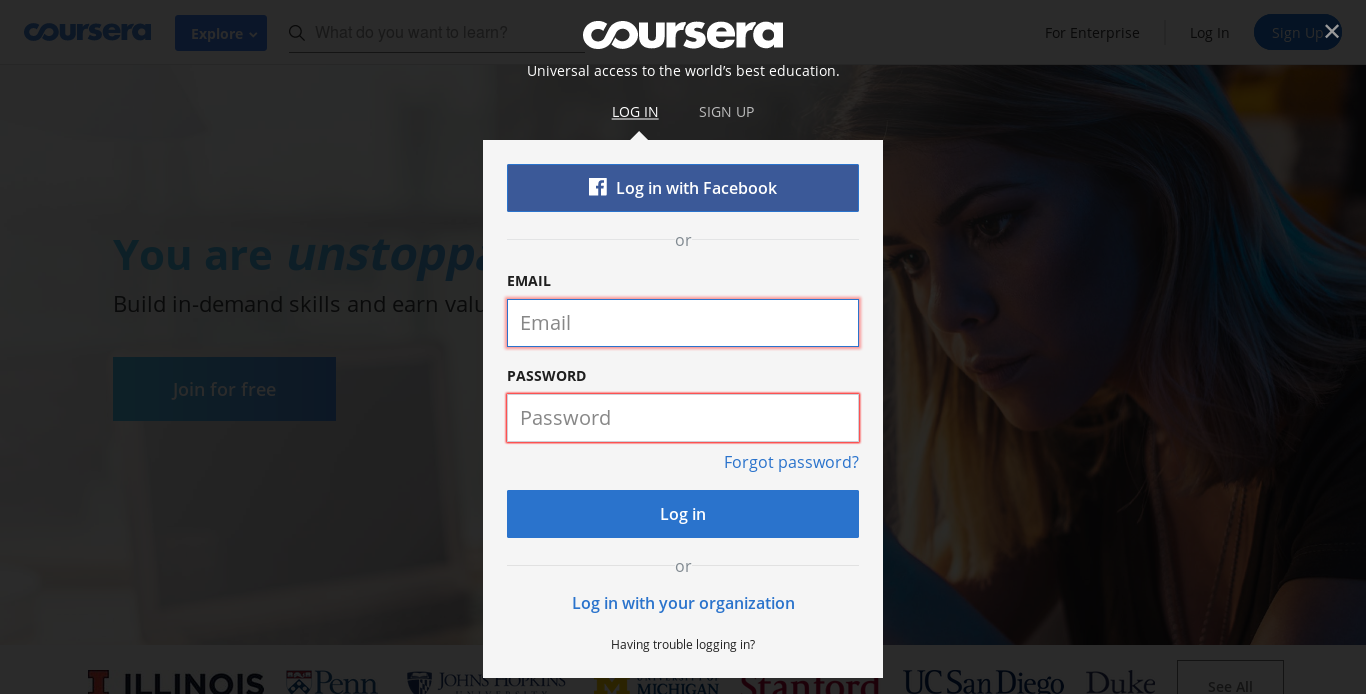

In [16]:
browser.visit('https://www.coursera.org/?authMode=login')
screenshot()

### Insert Login Credential

In [17]:
#reset_credential() #uncomment to reset 
username, password = get_credential()

In [18]:
browser.visit('https://www.coursera.org/courses?authMode=login')

In [19]:
browser.fill('email', username)
browser.fill('password', password)

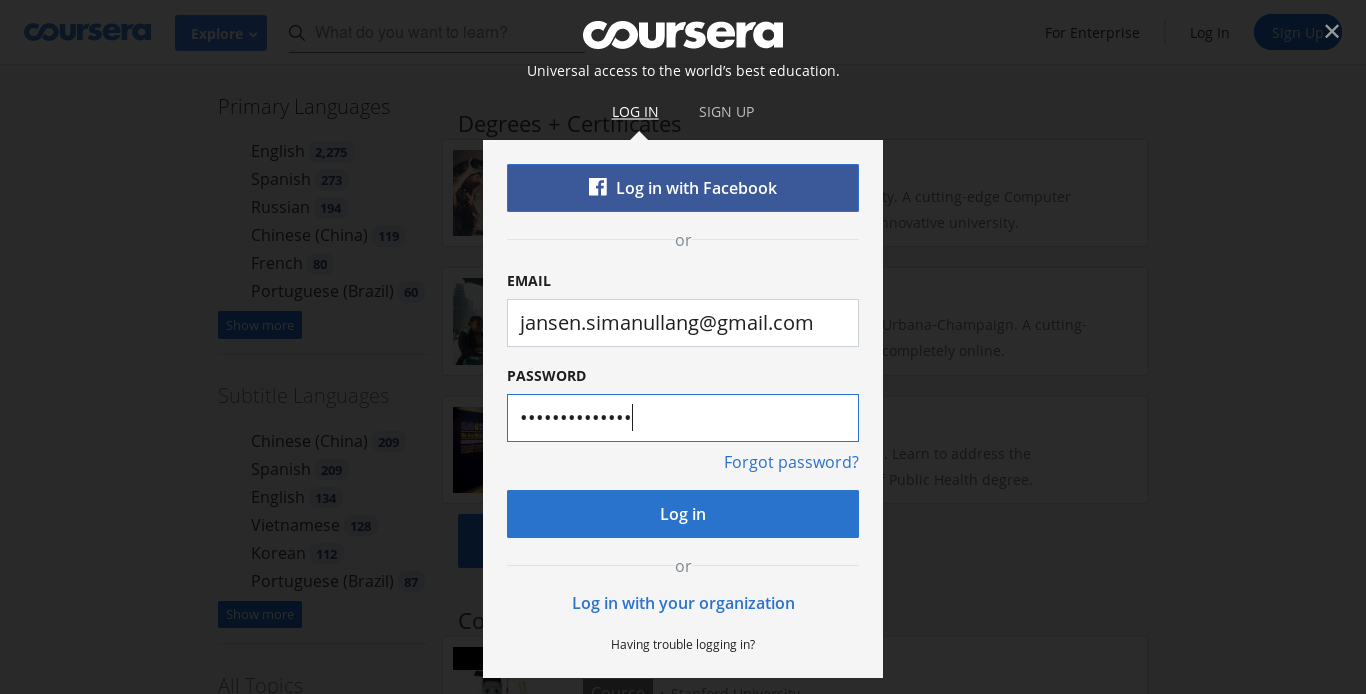

In [20]:
screenshot()

In [21]:
buttons = browser.find_by_tag('button')
for button in buttons:
    if (button.text == 'Log in'):
        button.click()
        break

### LAST ACTIVE COURSES

In [22]:
browser.visit(homepage)
section = browser.find_by_tag('section')
titles = []

for s in section:
    title = s.find_by_tag('h4').text
    titles.append(title)
    
for i, title in enumerate(titles):
    print(i+1, title)

1 How to Win a Data Science Competition: Learn from Top Kagglers
2 Algorithms on Graphs
3 Stochastic processes
4 Advanced Algorithms and Complexity
5 Data Structures
6 Algorithms on Strings
7 Algorithmic Toolbox
8 Version Control with Git
9 Control of Mobile Robots
10 Structuring Machine Learning Projects
11 Exploratory Data Analysis
12 Exploratory Data Analysis
13 Reproducible Research


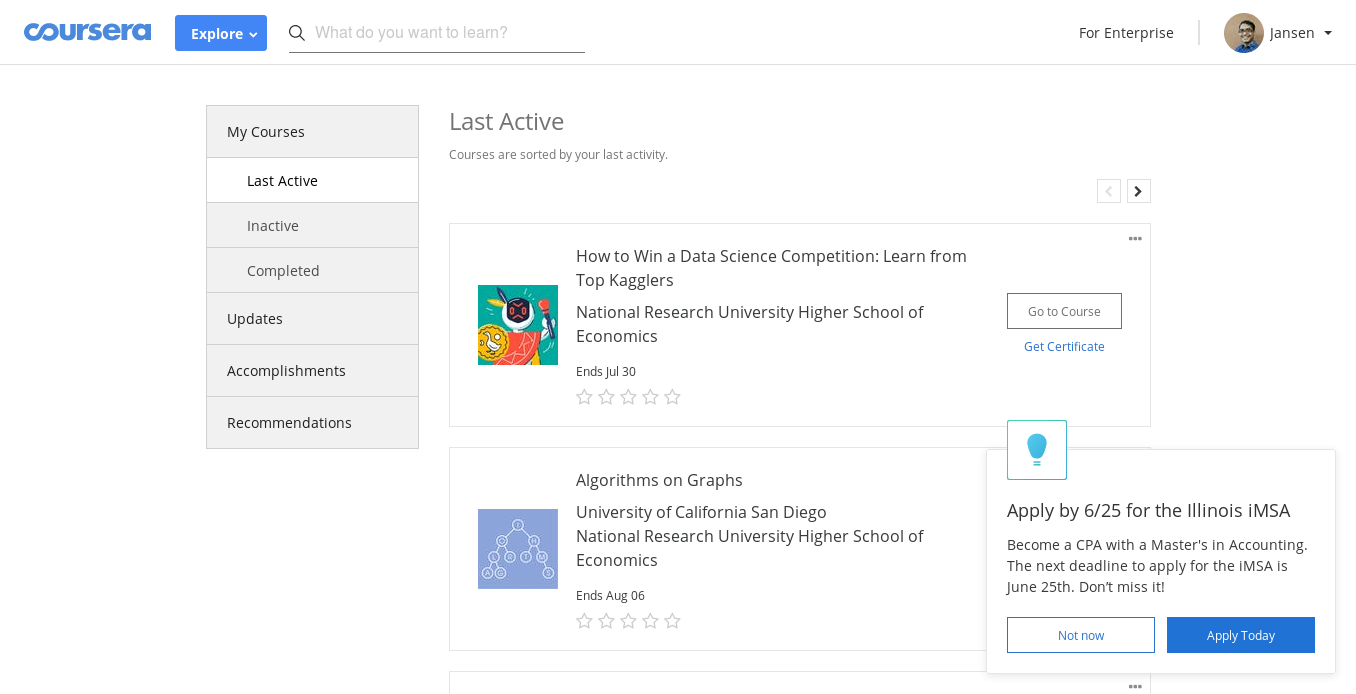

In [23]:
screenshot()

There are {{len(titles)}} courses visible in this section you can pick to download.

### PICK ONE OF THE COURSES

In [24]:
try:
    chosen_course = int(input('Choose a course number from [1] to ['+ str(len(titles))+']:\n'))
except:
    chosen_course = 1
course_title = titles[chosen_course-1]
print('>> You choose:\n'+course_title)

Choose a course number from [1] to [13]:
1
>> You choose:
How to Win a Data Science Competition: Learn from Top Kagglers


In [ ]:
section[chosen_course-1].click()
create_download_dir(course_title)

 ### {{ titles[chosen_course-1] }}

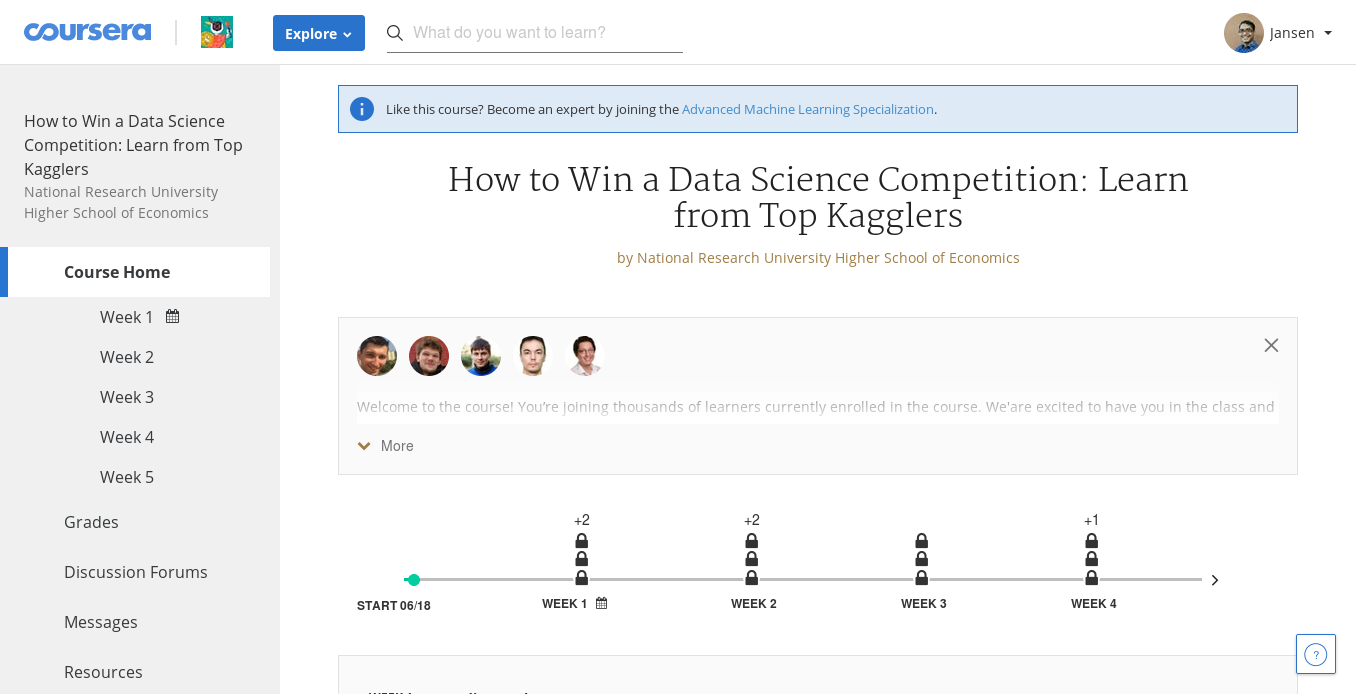

In [26]:
screenshot()

In [27]:
lecture_homepage = browser.driver.current_url

In [28]:
week = browser.find_by_css('div.rc-WeekCollectionNavigationItem > div')
anchors = BeautifulSoup(week.html, 'lxml').findAll('a', attrs={})
weeks = []
for a in anchors:
    weeks.append(a['href'])

weeks, len(weeks)

(['/learn/competitive-data-science/home/week/1',
  '/learn/competitive-data-science/home/week/2',
  '/learn/competitive-data-science/home/week/3',
  '/learn/competitive-data-science/home/week/4',
  '/learn/competitive-data-science/home/week/5'],
 5)

In [29]:
lessons_i = []
lessons_t = []
lessons_u = []
    
for w in range(len(weeks)):
    
    print('collecting lessons title and urls...\n')    
    browser.visit(homepage + weeks[w])
    
    w = w+1
    
    print('\nVisiting week: ' + str(w))
    time.sleep(loading_time)
    module_lessons = browser.find_by_css('div.rc-ModuleLessons')
    
    print()    
    print('Week '+str(w)+' titles:')
    lessons_title = module_lessons.find_by_tag('h5')
    for j, l in enumerate(lessons_title):
        lesson_id = str(w*100+j+1).zfill(3)
        title = l.text.replace('\n',' ')
        print(lesson_id, title)
        title = safe_text(title)
        lessons_t.append(title)
        lessons_i.append(lesson_id)
    
    print()    
    print('Week '+str(w)+' links:')    
    lessons_url = module_lessons.find_by_tag('ul')
    seq = 0
    for i, e in enumerate(lessons_url):
        anchors = BeautifulSoup(e.html, 'lxml').findAll('a')
        for j, a in enumerate(anchors):
            seq += 1
            lesson_id = str(w*100+seq).zfill(3)
            lesson_url = a['href']
            print(lesson_id, lesson_url)
            lessons_u.append(lesson_url)
           
    print()

collecting lessons title and urls...


Visiting week: 1

Week 1 titles:
101 Lecture Introduction
102 Reading Welcome!
103 Lecture Meet your lecturers
104 Lecture Course overview
105 Reading Week 1 overview
106 Lecture Competition Mechanics
107 Lecture Kaggle Overview [screencast]
108 Lecture Real World Application vs Competitions
109 Practice Quiz: Practice Quiz
110 Lecture Recap of main ML algorithms
111 Reading Disclaimer
112 Practice Quiz: Recap
113 Quiz: Recap
114 Reading Explanation for quiz questions
115 Will performance of GBDT model drop dramatically if we remove the first tree?
116 Reading Additional Materials and Links
117 Lecture Software/Hardware Requirements
118 Practice Quiz: Software/Hardware
119 Pandas basics
120 Programming Assignment: Pandas basics
121 Quiz: Graded Soft/Hard Quiz
122 Reading Explanation for quiz questions
123 Reading Additional Material and Links

Week 1 links:
101 /learn/competitive-data-science/lecture/BnRbe/introduction
102 /learn/competitive-data-

### Download Lecture Videos and Readings

In [ ]:
lessons = zip(lessons_i, lessons_t, lessons_u)
for a,b,c in lessons:
    print(a,b)
    first_word = b.split(' ')[0]
    
    if 'Lecture' in first_word:
        mp4_downloader(a,b,c)
        print()
        
    elif 'Reading' in first_word:
        get_reading_item(a, b, c)
        print()        
    
    else:
        print('no resource to download.')
        
    print()

os.chdir(initial_dirname)

101 Lecture Introduction
video playing will be paused in 10 seconds...
requesting to download...
file already downloaded.


102 Reading Welcome!
got reading item


103 Lecture Meet your lecturers
video playing will be paused in 10 seconds...
requesting to download...
file already downloaded.


104 Lecture Course overview
video playing will be paused in 10 seconds...
requesting to download...


In [ ]:
print('Resources downloaded to:\n'+os.getcwd())

## Screenshot Checking

In case of an error, you may want to check the screenshot. Here is an example:

In [ ]:
screenshot()

## Manually Calling `mp4_downloader`

In case you need to manually call `mp4_downloader` here is an example:

```
mp4_downloader('201',
               'Lecture Driving Robots Around?', 
               '/learn/mobile-robot/lecture/4HvCW/driving-robots-around')
````
`201` means week `2` lecture `01`

## Close Browser After Download

In [ ]:
browser.quit()

In [ ]:
os.chdir(initial_dirname)
os.getcwd()